In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
from petTOAD_analyses_helpers import *

In [3]:
# Set the best a that we used (from the literature) and load the best G that was previously found in the group-wise analyses.
a = -0.02
df_best_G = pd.read_csv(SIM_GROUP_DIR / "group-CN-no-WMH_desc-best-G.csv", index_col=0)
best_G = float(df_best_G["K_gl"])
# Load the list of subjects that were simulated
all_wmh_subjs = (
    pd.read_csv(RES_DIR / "subjs_to_sim.csv", index_col=0).iloc[:, 0].to_list()
)

# Load the clinical dataframe with the groupings and peform some polishing
df_petTOAD_pre = pd.read_csv(RES_DIR / "df_petTOAD.csv", index_col=0)
df_petTOAD_pre["WMH_bin"] = np.where(
    df_petTOAD_pre["Group_bin_Fazekas"].str.contains("no_WMH"), "no_WMH", "WMH"
)
# We work with the wmh log-transformed
df_petTOAD_pre["wmh_log"] = np.log10(
    df_petTOAD_pre["WMH_load_subj_space"],
    where=(df_petTOAD_pre["WMH_load_subj_space"] != 0),
    out=np.zeros_like(df_petTOAD_pre["WMH_load_subj_space"]),
)

# Normalize in the 0-1 range
df_petTOAD_pre["wmh_log_norm"] = (
    df_petTOAD_pre["wmh_log"] - df_petTOAD_pre["wmh_log"].min()
) / (df_petTOAD_pre["wmh_log"].max() - df_petTOAD_pre["wmh_log"].min())
df_petTOAD_pre["Acq Date"] = pd.to_datetime(df_petTOAD_pre["Acq Date"])
df_petTOAD_pre["high_wmh_bin"] = np.where(
    df_petTOAD_pre["Fazekas_lobar"] + df_petTOAD_pre["Fazekas_periventricular"] > 5,
    "high_wmh",
    "low_wmh",
)
# Create a df for simulated subjects only
df_petTOAD = df_petTOAD_pre[df_petTOAD_pre["PTID"].isin(all_wmh_subjs)].copy()
low_wmh_subjs = df_petTOAD[df_petTOAD["high_wmh_bin"] == "low_wmh"]["PTID"].values
high_wmh_subjs = df_petTOAD[df_petTOAD["high_wmh_bin"] == "high_wmh"]["PTID"].values
df_high_wmh = df_petTOAD[df_petTOAD["high_wmh_bin"] == "high_wmh"]
df_high_wmh.to_csv(RES_DIR / "high_wmh_subjs.csv")

In [4]:
# Load the plotting-ready dfs
df_model_comparison_wmh_long, df_model_comparison_wmh_wide = (
    prepare_group_df_for_plotting(all_wmh_subjs)
)
df_model_comparison_high_wmh_long, df_model_comparison_high_wmh_wide = (
    prepare_group_df_for_plotting(high_wmh_subjs)
)

In [5]:
# Calculate model differences
df_model_diffs, df_model_diffs_wide = calculate_model_diffs(
    df_model_comparison_wmh_wide
)
df_model_diffs = pd.merge(
    df_model_diffs_wide,
    df_petTOAD[["PTID", "wmh_log", "MMSE", "high_wmh_bin", "PTEDUCAT", "Age"]],
    on="PTID",
)
# Go from ratio of improvement to %
df_model_diffs["phfcd_ks_diff_base_G"] = df_model_diffs["phfcd_ks_diff_base_G"] * 100
df_model_diffs["phfcd_ks_diff_base_disconn"] = (
    df_model_diffs["phfcd_ks_diff_base_disconn"] * 100
)
df_model_diffs["phfcd_ks_diff_base_a"] = df_model_diffs["phfcd_ks_diff_base_a"] * 100
df_model_diffs["phfcd_ks_diff_base_het"] = (
    df_model_diffs["phfcd_ks_diff_base_het"] * 100
)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

sdc_baseline vs. sdc_homogeneous: Wilcoxon test (paired samples), P_val:2.019e-03 Stat=1.216e+03
sdc_baseline vs. sdc_heterogeneous: Wilcoxon test (paired samples), P_val:4.231e-02 Stat=1.470e+03
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

sdc_baseline vs. sdc_homogeneous: Wilcoxon test (paired samples), P_val:2.505e-03 Stat=3.700e+01
bif_parm_baseline vs. bif_parm_homogeneous: Wilcoxon test (paired samples), P_val:3.588e-02 Stat=6.200e+01
bif_parm_baseline vs. bif_parm_heterogeneous: Wilcoxon test (paired samples), P_val:3.588e-02 Stat=6.200e+01
sdc_baseline vs. sdc_heterogeneous: Wilcoxon test (paired samples), P_val:5.276e-03 Stat=4.300e+01


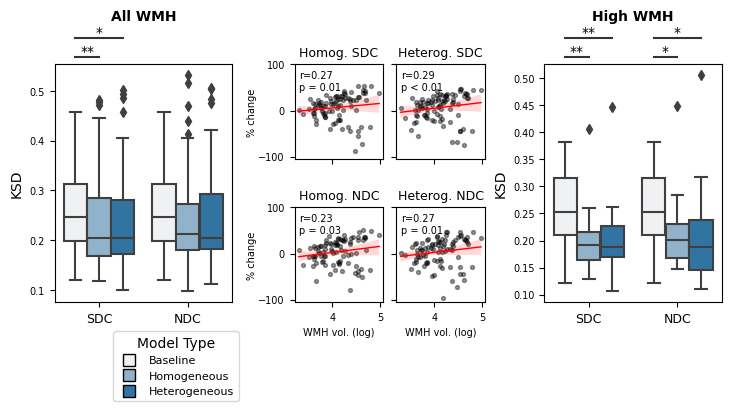

In [6]:
# Figure 3C-E
model_types = ["baseline", "homogeneous", "heterogeneous"]
model_names = ["Baseline", "Homogeneous", "Heterogeneous"]

tick_fontsize = 7
title_fontsize = 10

fig = plt.figure(figsize=(7.2, 4), constrained_layout=True)
axs = fig.subplot_mosaic(
    [["L", "M1", "M2", "R"], ["L", "M3", "M4", "R"]],
    gridspec_kw={"width_ratios": [1, 0.5, 0.5, 1], "height_ratios": [0.5, 0.5]},
)

# Plot comparison in all wmh subjects
plot_comparison(df_model_comparison_wmh_long, "phfcd_ks", axs["L"])
sns.regplot(
    data=df_model_diffs,
    x="wmh_log",
    y="phfcd_ks_diff_base_G",
    ax=axs["M1"],
    color="k",
    scatter_kws={"s": 8, "alpha": 0.4},
    line_kws={"color": "red", "linewidth": 1},
)
sns.regplot(
    data=df_model_diffs,
    x="wmh_log",
    y="phfcd_ks_diff_base_disconn",
    ax=axs["M2"],
    color="k",
    scatter_kws={"s": 8, "alpha": 0.4},
    line_kws={"color": "red", "linewidth": 1},
)
sns.regplot(
    data=df_model_diffs,
    x="wmh_log",
    y="phfcd_ks_diff_base_a",
    ax=axs["M3"],
    color="k",
    scatter_kws={"s": 8, "alpha": 0.4},
    line_kws={"color": "red", "linewidth": 1},
)
sns.regplot(
    data=df_model_diffs,
    x="wmh_log",
    y="phfcd_ks_diff_base_het",
    ax=axs["M4"],
    color="k",
    scatter_kws={"s": 8, "alpha": 0.4},
    line_kws={"color": "red", "linewidth": 1},
)

# Write the correlation values corrected by Age
write_corr_pval(
    df_model_diffs,
    "wmh_log",
    "phfcd_ks_diff_base_G",
    axs["M1"],
    tick_fontsize,
    correct_age=True,
)
write_corr_pval(
    df_model_diffs,
    "wmh_log",
    "phfcd_ks_diff_base_disconn",
    axs["M2"],
    tick_fontsize,
    correct_age=True,
)
write_corr_pval(
    df_model_diffs,
    "wmh_log",
    "phfcd_ks_diff_base_a",
    axs["M3"],
    tick_fontsize,
    correct_age=True,
)
write_corr_pval(
    df_model_diffs,
    "wmh_log",
    "phfcd_ks_diff_base_het",
    axs["M4"],
    tick_fontsize,
    correct_age=True,
)
# Plot comparison in high wmh subjects
plot_comparison(df_model_comparison_high_wmh_long, "phfcd_ks", axs["R"])

axs["L"].set_xticklabels(["SDC", "NDC"])
axs["L"].tick_params(axis="y", which="major", labelsize=tick_fontsize)
axs["L"].tick_params(axis="x", which="major", labelsize=tick_fontsize + 2)
axs["L"].set_xlabel("")

axs["M1"].set_title("Homog. SDC", fontsize=tick_fontsize + 2)
axs["M1"].set_ylabel(r"% change", fontsize=tick_fontsize, labelpad=1)
axs["M1"].set_xlabel("")
axs["M1"].set_xticklabels("")
axs["M1"].tick_params(axis="both", which="major", labelsize=tick_fontsize)

axs["M2"].set_title("Heterog. SDC", fontsize=tick_fontsize + 2)
axs["M2"].set_ylabel(r"% change", fontsize=tick_fontsize)
axs["M2"].set_xlabel("")
axs["M2"].set_ylabel("")
axs["M2"].set_xticklabels("")
axs["M2"].set_yticklabels("")
axs["M2"].tick_params(axis="both", which="major", labelsize=tick_fontsize)

axs["M3"].set_title("Homog. NDC", fontsize=tick_fontsize + 2)
axs["M3"].set_ylabel(r"% change", fontsize=tick_fontsize, labelpad=1)
axs["M3"].set_xlabel("WMH vol. (log)", fontsize=tick_fontsize)
axs["M3"].tick_params(axis="both", which="major", labelsize=tick_fontsize)

axs["M4"].set_title("Heterog. NDC", fontsize=tick_fontsize + 2)
axs["M4"].set_ylabel("")
axs["M1"].set_ylim(-105, 100)
axs["M2"].set_ylim(-105, 100)
axs["M3"].set_ylim(-105, 100)
axs["M4"].set_ylim(-105, 100)
axs["M4"].set_yticklabels("")
axs["M4"].set_xlabel("WMH vol. (log)", fontsize=tick_fontsize)
axs["M4"].tick_params(axis="both", which="major", labelsize=tick_fontsize)

axs["R"].set_title("High WMH", y=1.15, fontsize=title_fontsize, fontweight="bold")
axs["R"].set_xticklabels(["SDC", "NDC"])
axs["R"].tick_params(axis="y", which="major", labelsize=tick_fontsize)
axs["R"].tick_params(axis="x", which="major", labelsize=tick_fontsize + 2)
axs["R"].set_xlabel("")

axs["L"].set_title("All WMH", y=1.15, fontsize=title_fontsize, fontweight="bold")
# # Create a legend with model types and colors
colors = [patch.get_facecolor() for patch in axs["L"].patches][:-4:2]
legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="s",
        color="w",
        label=parm_type,
        markerfacecolor=color,
        markersize=8,
        markeredgecolor="black",
    )
    for parm_type, color in zip(model_names, colors)
]
axs["L"].legend(
    handles=legend_elements,
    title="Model Type",
    bbox_to_anchor=[0.3, -0.1],
    fontsize=8,
    title_fontsize=10,
)
fig.savefig(FIG_DIR / "fig3C-E_boxplots_comparisons.png", dpi=700)

In [7]:
# Table 1 Performance of WMH-weighted models vs baseline

print("The following comparisons survives FDR when considering all subjects:")
p_values_comparison_all, bh = calculate_pvalue_comparison_long(df_model_comparison_wmh_long, 'phfcd_ks')
print("The following comparisons survives FDR when considering only high WMH subjects:")
p_values_comparison_high_wmh, bh2 = calculate_pvalue_comparison_long(df_model_comparison_high_wmh_long, 'phfcd_ks')

tbl_compare_models_left = create_table_comparison_long(df_model_comparison_wmh_long, "All WMH", p_values_comparison_all)
tbl_compare_models_right = create_table_comparison_long(df_model_comparison_high_wmh_long, "High WMH", p_values_comparison_high_wmh)
tbl_compare_models_together = pd.merge(tbl_compare_models_left, tbl_compare_models_right, on = "Model Name")
tbl_compare_models_together

The following comparisons survives FDR when considering all subjects:
(('sdc', 'homogeneous'), ('sdc', 'baseline'))
The following comparisons survives FDR when considering only high WMH subjects:
(('sdc', 'homogeneous'), ('sdc', 'baseline'))
(('sdc', 'heterogeneous'), ('sdc', 'baseline'))
(('bif_parm', 'homogeneous'), ('bif_parm', 'baseline'))
(('bif_parm', 'heterogeneous'), ('bif_parm', 'baseline'))


/tmp/ipykernel_1305956/3990404239.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  tbl_compare_models_together = pd.merge(tbl_compare_models_left, tbl_compare_models_right, on = "Model Name")


Model Name           All WMH                     High WMH           
                                   KSD    p-value               KSD    p-value
0           Baseline  0.25 (0.20-0.31)             0.25 (0.21-0.32)           
1    Homogeneous SDC  0.20 (0.17-0.29)  **0.002**  0.19 (0.16-0.22)  **0.003**
2  Heterogeneous SDC  0.20 (0.17-0.28)  **0.042**  0.19 (0.17-0.23)  **0.005**
3    Homogeneous NDC  0.21 (0.18-0.27)       0.17  0.20 (0.17-0.23)  **0.036**
4  Heterogeneous NDC  0.21 (0.18-0.29)       0.12  0.19 (0.14-0.24)  **0.036**

In [8]:
# Load the random models
df_model_comparison_rand_wmh_long = prepare_group_df_for_plotting(
    all_wmh_subjs, is_random=True
)
df_model_rand_vs_non_rand = pd.concat(
    [df_model_comparison_wmh_long, df_model_comparison_rand_wmh_long]
)
# It doesn't make sense to compare the baseline to a random so we drop it
df_plotting_random = (
    df_model_rand_vs_non_rand[df_model_rand_vs_non_rand["model_type"] != "baseline"]
    .copy()
    .reset_index(drop=True)
)
# The format for plotting is slightly different from before, so we create a column combining the parameter type and the model type
df_plotting_random["homo_het"] = np.where(
    df_plotting_random["model_type"].str.contains("homogeneous"),
    df_plotting_random["parm_type"] + "_homogeneous",
    df_plotting_random["parm_type"] + "_heterogeneous",
)
df_plotting_random["random"] = np.where(
    df_plotting_random["model_type"].str.contains("random"), "random", "not_random"
)
pvalues_comparisons_random = calculate_pvals_random_comparisons(df_plotting_random)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

sdc_heterogeneous_not_random vs. sdc_heterogeneous_random: Custom statistical test, P_val:2.813e-03
sdc_homogeneous_not_random vs. sdc_homogeneous_random: Custom statistical test, P_val:4.147e-02
bif_parm_homogeneous_not_random vs. bif_parm_homogeneous_random: Custom statistical test, P_val:5.630e-01
bif_parm_heterogeneous_not_random vs. bif_parm_heterogeneous_random: Custom statistical test, P_val:5.509e-02


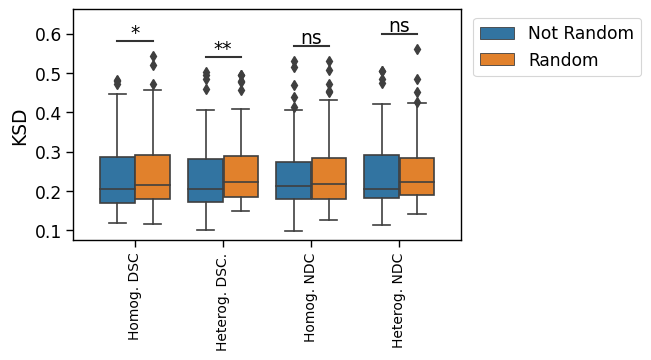

In [9]:
order = [
    "sdc_homogeneous",
    "sdc_heterogeneous",
    "bif_parm_homogeneous",
    "bif_parm_heterogeneous",
]
random_order = ["not_random", "random"]
pairs = [
    (("sdc_homogeneous", "random"), ("sdc_homogeneous", "not_random")),
    (("sdc_heterogeneous", "random"), ("sdc_heterogeneous", "not_random")),
    (("bif_parm_homogeneous", "random"), ("bif_parm_homogeneous", "not_random")),
    (("bif_parm_heterogeneous", "random"), ("bif_parm_heterogeneous", "not_random")),
]
with sns.plotting_context("paper", font_scale=1.4):
    fig, ax = plt.subplots(1, figsize=(5, 3))
    hue_plot_params = {
        "data": df_plotting_random,
        "x": "homo_het",
        "y": "phfcd_ks",
        "order": order,
        "hue": "random",
        "hue_order": random_order,
    }

    sns.boxplot(ax=ax, **hue_plot_params)
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(
        hide_non_significant=False, line_offset=0.1, line_height=0.0, text_offset=-1
    )
    annotator.set_pvalues([pval for pval in pvalues_comparisons_random.values()])
    annotator.annotate()
    ax.set_ylabel("KSD")
    ax.set_xlabel("")
    ax.set_xticklabels(
        ["Homog. DSC", "Heterog. DSC.", "Homog. NDC", "Heterog. NDC"],
        fontsize=10,
        rotation=90,
    )

    legend = ax.legend(bbox_to_anchor=[1.01, 1])
    new_labels = ["Not Random", "Random"]
    for text, new_label in zip(legend.get_texts(), new_labels):
        text.set_text(new_label)
    fig.savefig(FIG_DIR / "suppl_fig4_random_comparison.png", dpi=700)

In [10]:
# Suppl. Table 2 Performance of random vs. non random models

tbl_rand_vs_non_rand = format_table_compare_rand_non_rand(df_plotting_random, pvalues_comparisons_random)
tbl_rand_vs_non_rand

,Model Name,KSD Random,KSD Non-random,p-value
0,Homogeneous SDC,0.22 (0.18-0.29),0.20 (0.17-0.29),**0.041**
1,Heterogeneous SDC,0.22 (0.19-0.29),0.20 (0.17-0.28),**0.003**
2,Homogeneous NDC,0.22 (0.18-0.28),0.21 (0.18-0.27),0.563
3,Heterogeneous NDC,0.22 (0.19-0.28),0.21 (0.18-0.29),0.055


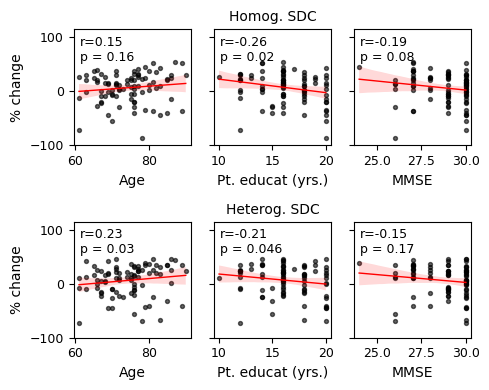

In [11]:
# Fig. 4 - Correlation between % of improvement from the baseline and clinical variables for SDC models

fig, axs = plt.subplots(2, 3, figsize=(5, 4), sharey=True)

sns.regplot(
    data=df_model_diffs,
    x="Age",
    y="phfcd_ks_diff_base_G",
    ax=axs[0, 0],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="PTEDUCAT",
    y="phfcd_ks_diff_base_G",
    ax=axs[0, 1],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="MMSE",
    y="phfcd_ks_diff_base_G",
    ax=axs[0, 2],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)

sns.regplot(
    data=df_model_diffs,
    x="Age",
    y="phfcd_ks_diff_base_disconn",
    ax=axs[1, 0],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="PTEDUCAT",
    y="phfcd_ks_diff_base_disconn",
    ax=axs[1, 1],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="MMSE",
    y="phfcd_ks_diff_base_disconn",
    ax=axs[1, 2],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)


axs[0, 0].set_ylabel(r"% change")
axs[0, 1].set_ylabel("")
axs[0, 2].set_ylabel("")

axs[1, 0].set_ylabel(r"% change")
axs[1, 1].set_ylabel(
    "",
)
axs[1, 2].set_ylabel("")

axs[0, 1].set_xlabel("Pt. educat (yrs.)")
axs[1, 1].set_xlabel("Pt. educat (yrs.)")

axs[0, 0].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[0, 1].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[0, 2].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[1, 0].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[1, 1].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[1, 2].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)

# Slightly increase the axis to have more space for writing the correlation results
axs[0, 0].set_ylim(-100, 115)
axs[0, 1].set_ylim(-100, 115)
axs[0, 2].set_ylim(-100, 115)
axs[1, 0].set_ylim(-100, 115)
axs[1, 1].set_ylim(-100, 115)
axs[1, 2].set_ylim(-100, 115)

write_corr_pval(
    df_model_diffs,
    "Age",
    "phfcd_ks_diff_base_G",
    axs[0, 0],
    fontsize=9,
    correct_age=False,
)
write_corr_pval(
    df_model_diffs,
    "PTEDUCAT",
    "phfcd_ks_diff_base_G",
    axs[0, 1],
    fontsize=9,
    correct_age=True,
)
write_corr_pval(
    df_model_diffs,
    "MMSE",
    "phfcd_ks_diff_base_G",
    axs[0, 2],
    fontsize=9,
    correct_age=True,
)

write_corr_pval(
    df_model_diffs,
    "Age",
    "phfcd_ks_diff_base_disconn",
    axs[1, 0],
    fontsize=9,
    correct_age=False,
)
write_corr_pval(
    df_model_diffs,
    "PTEDUCAT",
    "phfcd_ks_diff_base_disconn",
    axs[1, 1],
    fontsize=9,
    correct_age=True,
)
write_corr_pval(
    df_model_diffs,
    "MMSE",
    "phfcd_ks_diff_base_disconn",
    axs[1, 2],
    fontsize=9,
    correct_age=True,
)

axs[0, 1].set_title("Homog. SDC", fontsize=title_fontsize)
axs[1, 1].set_title("Heterog. SDC", fontsize=title_fontsize)
fig.tight_layout()
fig.savefig(FIG_DIR / "fig4_corrplots_sdc.png", dpi=700)

In [12]:
# Table 2 Correlation between demographic variables and improvements in model performance

create_table_corr_model_improvement(df_model_diffs)

Demographic variable Homogeneous SDC            Heterogeneous SDC  \
                                     r    p-value                 r   
0     WMH Volume (log)            0.27  **0.010**              0.29   
1                  Age            0.15       0.16              0.23   
2                 MMSE           -0.19       0.08             -0.15   
3      Education (yrs)           -0.26  **0.015**             -0.21   

             Homogeneous NDC            Heterogeneous NDC             
     p-value               r    p-value                 r    p-value  
0  **0.007**            0.23  **0.035**              0.27  **0.012**  
1  **0.028**            0.21      0.052              0.10       0.35  
2       0.17           -0.13       0.24             -0.10       0.36  
3  **0.046**           -0.21      0.055             -0.16       0.14

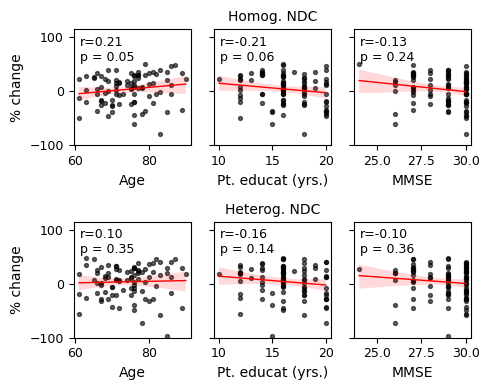

In [13]:
# Suppl. Fig. 5 - Correlation between % of improvement from the baseline and clinical variables for NDC models

fig, axs = plt.subplots(2, 3, figsize=(5, 4), sharey=True)

sns.regplot(
    data=df_model_diffs,
    x="Age",
    y="phfcd_ks_diff_base_a",
    ax=axs[0, 0],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="PTEDUCAT",
    y="phfcd_ks_diff_base_a",
    ax=axs[0, 1],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="MMSE",
    y="phfcd_ks_diff_base_a",
    ax=axs[0, 2],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)

sns.regplot(
    data=df_model_diffs,
    x="Age",
    y="phfcd_ks_diff_base_het",
    ax=axs[1, 0],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="PTEDUCAT",
    y="phfcd_ks_diff_base_het",
    ax=axs[1, 1],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)
sns.regplot(
    data=df_model_diffs,
    x="MMSE",
    y="phfcd_ks_diff_base_het",
    ax=axs[1, 2],
    scatter_kws={"s": 8, "alpha": 0.6, "color": "black"},
    line_kws={"linewidth": 1, "color": "red"},
)


axs[0, 0].set_ylabel(r"% change")
axs[0, 1].set_ylabel("")
axs[0, 2].set_ylabel("")

axs[1, 0].set_ylabel(r"% change")
axs[1, 1].set_ylabel(
    "",
)
axs[1, 2].set_ylabel("")

axs[0, 1].set_xlabel("Pt. educat (yrs.)")
axs[1, 1].set_xlabel("Pt. educat (yrs.)")

axs[0, 0].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[0, 1].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[0, 2].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[1, 0].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[1, 1].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)
axs[1, 2].tick_params(axis="both", which="major", labelsize=tick_fontsize + 2)

# Slightly increase the axis to have more space for writing the correlation results
axs[0, 0].set_ylim(-100, 115)
axs[0, 1].set_ylim(-100, 115)
axs[0, 2].set_ylim(-100, 115)
axs[1, 0].set_ylim(-100, 115)
axs[1, 1].set_ylim(-100, 115)
axs[1, 2].set_ylim(-100, 115)

write_corr_pval(
    df_model_diffs,
    "Age",
    "phfcd_ks_diff_base_a",
    axs[0, 0],
    fontsize=9,
    correct_age=False,
)
write_corr_pval(
    df_model_diffs,
    "PTEDUCAT",
    "phfcd_ks_diff_base_a",
    axs[0, 1],
    fontsize=9,
    correct_age=True,
)
write_corr_pval(
    df_model_diffs,
    "MMSE",
    "phfcd_ks_diff_base_a",
    axs[0, 2],
    fontsize=9,
    correct_age=True,
)

write_corr_pval(
    df_model_diffs,
    "Age",
    "phfcd_ks_diff_base_het",
    axs[1, 0],
    fontsize=9,
    correct_age=False,
)
write_corr_pval(
    df_model_diffs,
    "PTEDUCAT",
    "phfcd_ks_diff_base_het",
    axs[1, 1],
    fontsize=9,
    correct_age=True,
)
write_corr_pval(
    df_model_diffs,
    "MMSE",
    "phfcd_ks_diff_base_het",
    axs[1, 2],
    fontsize=9,
    correct_age=True,
)

axs[0, 1].set_title("Homog. NDC", fontsize=title_fontsize)
axs[1, 1].set_title("Heterog. NDC", fontsize=title_fontsize)
fig.tight_layout()
fig.savefig(FIG_DIR / "suppl_fig5_corrplots_ndc.png", dpi=700)